# 説明
- pythonモジュールのamazon-product-APIを用いて、asin(アイテムID)、発売日、製造元、価格、saleserankを取得
- salserankは所属するカテゴリにおける順位
- asinは別のプログラムで、レビューに関する情報を取得する。
- APIで取得できる情報の一覧は下記のURL。

http://docs.aws.amazon.com/AWSECommerceService/latest/DG/CHAP_response_elements.html#ASIN

# amazon-product-api
- amazonAPI専用のモジュール
- amazonAPIは扱いが難しいため、作成された模様
- 元々APIで取得できるすべての情報を扱うことができないが、重要な情報はカバーしている

# 実施メモ
- 取得できる情報は検索結果の最初10ページのみで、それ以降のページの情報は取得できない。今回の場合は、価格範囲を決めて、繰り返し情報を取得
- 一時間でできるリクエスト回数は3600回となっているが、このペースでやるとエラーが頻発する。
- 回線が常に混雑しているのか、リクエスト回数を抑えても、結構な頻度でエラーが発生する。

In [8]:
from amazon.api import AmazonAPI
from bs4 import BeautifulSoup
import requests
import time
import numpy as np
import csv
#coding utf-8
f = open("/home/kyohei/amazon_rootkey/rootkey.csv","r")
rootkey = list(csv.reader(f))
access,secret = rootkey
AMAZON_ACCESS_KEY = access[0].replace("AWSAccessKeyId=","")
AMAZON_SECRET_KEY = secret[0].replace("AWSSecretKey=","")
AMAZON_ASSOC_TAG = "kyoheikoga04-22"
amazon = AmazonAPI(AMAZON_ACCESS_KEY,AMAZON_SECRET_KEY,AMAZON_ASSOC_TAG,region="JP")

In [9]:
prices = np.linspace(0,140000,141)
products_list = []
for price in prices:
    products = amazon.search(BrowseNode=2725002051,
                         SearchIndex='Electronics',
                         MinimumPrice=price,
                         MaximumPrice=(price + 999))
    time.sleep(5.0)
    products_list.append(products)

KeyboardInterrupt: 

In [3]:
rate_values = []
error_confirmation = []
for j,product in enumerate(products_list):
    try:
        for i,row in enumerate(product):
            response = requests.get(row.reviews[1])
            title = row.title
            asin = row.asin
            manufacturer = row.manufacturer
            date = row.release_date
            price = row.price_and_currency[0]
            rank = row.sales_rank
            rate_values.append([asin,
                               date,
                               manufacturer,
                               price,
                               rank])
    except Exception:
        error_confirmation.append(["error",i])

In [4]:
np.array(rate_values).shape

(651, 5)

In [19]:
import pandas as pd
column = ["asin","date","manufacturer","price","rank"]
data = pd.DataFrame(rate_values,columns=column)
data_renew = data.set_index("asin",drop=True)

# meker ranking 

In [20]:
data_renew["manufacturer"].value_counts()[:20]

STK                                        35
Indigi                                     32
Motorola                                   22
Pebble                                     14
Samsung                                    13
Flylinktech                                12
Shenzhen Wave                              12
株式会社フューチャーズ                                12
EasyDy                                     11
passion                                    11
Origin                                     10
FLOVEME                                    10
Shenzhen Yoluke Technology Co., Limited     9
Sony                                        9
Garmin                                      8
Sincere　Inc.                                7
EloBeth                                     7
Floveme                                     7
KESS Global Inc.                            7
Tera                                        6
Name: manufacturer, dtype: int64

# comment
・petty lisaはスマートウォッチではなく、通常の腕時計の会社

・STKは中国企業

・株式会社フューチャーズは輸入代理店

・KESS Global Inc.はapple watchのアクセサリー

In [22]:
data_renew["price"] = data_renew["price"].astype(float)
data_renew["rank"] = data_renew["rank"].astype(float)
# data_renew = data_renew[data_renew["manufacturer"] != "Petty Lisa"]

# 価格分布

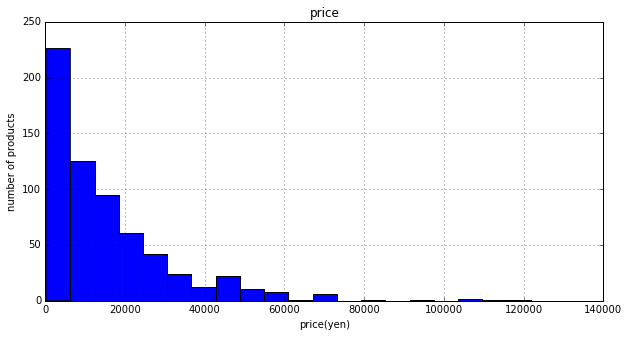

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
data_renew.hist("price",bins=20,figsize=(10,5))
plt.xlabel("price(yen)")
plt.ylabel("number of products")
plt.show()

# salse_rank

In [24]:
data_renew.sort_values("rank",ascending=True).head(20)

date              manufacturer    price    rank
asin                                                             
B01GCV6FQS        None                 easybuyjp   1099.0   435.0
B01E8WJOY8        None                 easybuyjp   1195.0   930.0
B00Y2CYYQ8        None                    Pebble  14425.0  1245.0
B015ATF9I8        None                  MisSmart   5680.0  1658.0
B0041G52PC  2010-11-11  Sleep tracker(スリープトラッカー)  18780.0  2059.0
B01FJAQRRK  2016-06-17                    Fitbit  26297.0  2076.0
B01FLLSJ6E        None                 Eagle　Eye   2737.0  2104.0
B01HBRPSZG        None                 Tryangle.   2500.0  2822.0
B016COOLGQ        None                  Motorola  47800.0  4427.0
B012CV1VMK        None             Shenzhen Wave   1899.0  4508.0
B01AIH5V0S        None                    Antech   2000.0  4524.0
B00DNDF2OU        None                      Sony  13200.0  5551.0
B016OD9YEY        None                      Asus  17900.0  5573.0
B015Z7O73I  2015-10-16                    HUAWEI  44060.0  5911.0
B01FW4ML4Q        None               LAD WEATHER   9800.0  6025.0
B00H7ASLVG        None                    Pebble  10500.0  6600.0
B00PC7PDSA        None                  Motorola  19979.0  7198.0
B01GO3B938        None                       PMJ   2980.0  7901.0
B00N9OAQI0        None                       ソニー  22380.0  8231.0
B01FFAZIR4  2016-05-19                  Withings  22790.0  8528.0

In [25]:
data_renew.to_csv("amazon_smart_watch.csv",encoding="utf-8")